#**Improvements / fixes needed in this notebook:**


1.   Dataset Class creation for ut-zappos and proper relevant data / path handling. (Done, Inference also done)
2.   Model re-loading and inference not working properly, correct its functionality and test it. **(Very Important)**
3.   Research and add relevant evaluation metrics that would indicate the score or quality of generated prompt, as our task is primarily concerned with prompt fine-tuning. **(Very Very Important)**

Kindly see the following chat https://chatgpt.com/share/674e5e47-afac-800e-b488-b481dac28448 for a starter on what evaluation metrics can be used. This needs to be further researched and properly implemented for the final version of our project. (Important)

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
steer01_ut_zap50k_images_path = kagglehub.dataset_download('steer01/ut-zap50k-images')

print('Data source import complete.')
print(f"Dataset downloaded to: {steer01_ut_zap50k_images_path}")


100%|██████████| 169M/169M [00:10<00:00, 16.7MB/s]

Extracting files...


Data source import complete.
Dataset downloaded to: /root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1


In [2]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
%%time
import os
import json
from datasets import Dataset
from torch.utils.data import Dataset as TorchDataset, DataLoader
from PIL import Image
import torch
from transformers import AutoProcessor

# Define the base directory for images
BASE_DIR = "/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images"

# Load the JSON file
json_file = "/content/compositional_ut_zappos_prompts_cpu.json"  # Replace with your JSON file path
with open(json_file, 'r') as f:
    zappos_data = json.load(f)

# Convert JSON to a Pandas DataFrame
import pandas as pd
zappos_df = pd.DataFrame(zappos_data)

# Limit the dataset to 1,000 samples
subset_df = zappos_df.head(1000)

# Add the full path to the image file
subset_df['image_path'] = subset_df['image_path'].apply(lambda x: os.path.join(BASE_DIR, x))

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(subset_df)

# Map the dataset to match the expected format
dataset = dataset.map(lambda x: {"image": x["image_path"], "caption": x["new_prompt"]})

# Check the first 5 entries
print(dataset[0:5])


<timed exec>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'image_path': ['/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Acrylic_Sandals/7350693.3.jpg', '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Acrylic_Sandals/7350693.385.jpg', '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Acrylic_Sandals/7350693.632.jpg', '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Aluminum_Shoes.Sneakers.and.Athletic.Shoes/7225188.18276.jpg', '/root/.cache/kagglehub/datasets/steer01/ut-zap50k-images/versions/1/images/Aluminum_Shoes.Sneakers.and.Athletic.Shoes/7329179.1412.jpg'], 'new_prompt': ['A photo of Acrylic_Sandals with white color and fabric material', 'A photo of Acrylic_Sandals with white color and fabric material', 'A photo of Acrylic_Sandals with white color and fabric material', 'A photo of Acrylic_Sandals with an unspecified color and rubber material', 'A photo of Acrylic_Sandals with white color and rubber material'], 'shoe_type': ['Acr

In [5]:
class UTZapposDataset(TorchDataset):
    def __init__(self, hf_dataset, processor):
        """
        Args:
            hf_dataset: Hugging Face dataset with image paths and captions.
            processor: BLIP-2 processor for encoding images and tokenizing captions.
        """
        self.hf_dataset = hf_dataset
        self.processor = processor

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        # Load and process the image
        image = Image.open(item["image"]).convert("RGB")
        encoding = self.processor(images=image, return_tensors="pt", padding="max_length")
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}  # Remove batch dimension
        # Add text (caption)
        encoding["text"] = item["caption"]
        return encoding


def collate_fn(batch, processor):
    """
    Custom collate function to preprocess a batch of examples.
    """
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            # Tokenize captions
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch],
                padding=True,
                truncation=True,
                return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


In [6]:
%%time
from transformers import Blip2Processor
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

CPU times: user 576 ms, sys: 52.3 ms, total: 628 ms
Wall time: 9.68 s


In [7]:
%%time
# Create the dataset object
utzappos_dataset = UTZapposDataset(dataset, processor)

# Initialize the DataLoader
dataloader = DataLoader(
    utzappos_dataset,
    batch_size=3,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, processor)
)

# Test the DataLoader
for batch in dataloader:
    print(batch["pixel_values"].shape)  # Should be (batch_size, 3, height, width)
    print(batch["input_ids"].shape)  # Tokenized captions
    break


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([3, 3, 224, 224])
torch.Size([3, 29])
CPU times: user 61.5 ms, sys: 2.77 ms, total: 64.3 ms
Wall time: 192 ms


In [8]:
%%time
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig

quant_config = BitsAndBytesConfig(load_in_8bit=True)

CPU times: user 496 ms, sys: 61.8 ms, total: 557 ms
Wall time: 756 ms


In [9]:
%%time
model = Blip2ForConditionalGeneration.from_pretrained(
    "ybelkada/blip2-opt-2.7b-fp16-sharded",
    device_map="auto",
    quantization_config=quant_config)


print("Model loaded with 8-bit quantization.")

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Model loaded with 8-bit quantization.
CPU times: user 20 s, sys: 17.1 s, total: 37.1 s
Wall time: 6min 25s


In [10]:
%%time
from peft import LoraConfig, get_peft_model

# Define LoRA configuration
lora_config = LoraConfig(
    # task_type=TaskType.SEQ_2_SEQ_LM,  # Task type for BLIP-2
    r=16,  # Low-rank dimension (can be adjusted based on memory/performance trade-off)
    lora_alpha=32,  # Scaling factor for LoRA
    lora_dropout=0.1,  # Dropout to avoid overfitting
    target_modules=["q_proj", "v_proj"],  # BLIP-2 attention layers
    bias="none"  # No bias adaptation
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print trainable parameters to verify LoRA is applied
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398
CPU times: user 347 ms, sys: 19.2 ms, total: 366 ms
Wall time: 415 ms


In [11]:
processor.tokenizer.pad_token_id

1

In [12]:
%%time
import torch
from transformers import AdamW, get_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm

# Set up optimizer and scheduler
num_epochs = 15
optimizer = AdamW(model.parameters(), lr=5e-4)
num_training_steps = len(dataloader) * num_epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to GPU (if not already done)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
model.train()

for epoch in range(num_epochs):
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}")
    for batch in progress_bar:
        # Move batch data to device
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        # attention_mask = batch["attention_mask"].to(device)

        # Mask padding tokens in labels
        # labels = input_ids.clone()
        # labels[labels == processor.tokenizer.pad_token_id] = -100

        # Forward pass
        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            # attention_mask=attention_mask,
            labels=input_ids  # BLIP-2 auto-regressive generation
        )
        loss = outputs.loss
        # print(loss)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Update progress bar
        progress_bar.set_postfix(loss=loss.item())

    # Update learning rate scheduler
    # lr_scheduler.step()

# Save the fine-tuned model
model.save_pretrained("fine_tuned_blip2_lora")
print("Fine-tuning completed and model saved.")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 15: 100%|██████████| 334/334 [03:42<00:00,  1.50it/s, loss=0.0304]


Fine-tuning completed and model saved.
CPU times: user 49min 21s, sys: 5min 23s, total: 54min 45s
Wall time: 55min 4s


In [13]:
for name, param in model.named_parameters():
    if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
        print(f"Gradient issue in {name}")

In [14]:
import shutil

# Create a zip file of the fine-tuned model
shutil.make_archive("fine_tuned_blip2_lora", 'zip', "fine_tuned_blip2_lora")


'/content/fine_tuned_blip2_lora.zip'

In [15]:
from google.colab import files

# Download the zip file
files.download("fine_tuned_blip2_lora.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# INFERENCE

CPU times: user 1.93 ms, sys: 0 ns, total: 1.93 ms
Wall time: 1.74 ms


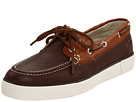

In [16]:
%%time
from PIL import Image
# load image
# example = dataset[0]
# image = example["image"]
# t_img_path = "/kaggle/input/inf-img-01/7909514.680.jpg"
# t_img_path = "/kaggle/input/inf-img-02/109671650_f7bbc297fa.jpg"
# t_img_path = "/content/109671650_f7bbc297fa.jpg"
t_img_path = "/content/7741089.324993.jpg"
image = Image.open(t_img_path).convert("RGB")
image

In [17]:
%%time

def generate_caption(image_path, model, processor, device, max_length=50):
    """
    Generate a caption for a given image using the fine-tuned BLIP-2 model.

    Args:
        image_path (str): Path to the image.
        model: Fine-tuned BLIP-2 model.
        processor: BLIP-2 processor for image and text.
        device: Device to run inference (CPU/GPU).
        max_length (int): Maximum length of the generated caption.

    Returns:
        str: Generated caption.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    # Generate caption
    with torch.no_grad():
        outputs = model.generate(
            pixel_values=inputs["pixel_values"],
            max_length=max_length,
            num_beams=5,  # Beam search for better results
            early_stopping=True
        )

    # Decode the generated text
    caption = processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
    return caption

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [18]:
%%time
# Example image path
# test_image_path = "/path/to/test_image.jpg"

# Generate caption
caption = generate_caption(t_img_path, model, processor, device)
print(f"Generated Caption: {caption}")

Generated Caption: A photo of Canvas_Shoes.Boat.Shoes with brown color and rubber material
CPU times: user 9.01 s, sys: 68 ms, total: 9.08 s
Wall time: 9.41 s
